In [1]:
import numpy as np
from matplotlib import pyplot as plt
from Node import Node
from Elastic import Elastic

import warnings
warnings.filterwarnings("ignore")

## Generate a network

In order to generate a network, we need to define the architecture. We specify the initial positions of the nodes and the connectivity of the edges. Here, we define the edge connectivity manually but choose node positions at random.

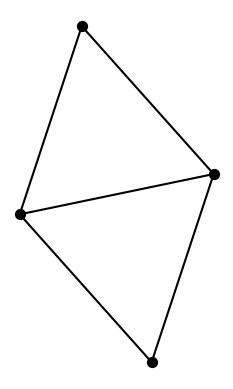

In [4]:
pos = np.random.uniform(0., 4., size=(4,2))
ecs = np.array([[0,1], [1,2], [2,3], [3,1], [3,0]])

e = Elastic(nodes = pos, edges = ecs)

e.plot_state(e.x0)

## Setting boundaries, sources, and targets

* A "boundary" node is a node whose position is fixed in ALL states.
* A "source" node is fixed in both the free and clamped states.
* A "target" node is fixed only in the clamped state.

Nodes are defined according to their index and position. The built-in plotting function colors source nodes blue, target nodes red, and boundary nodes gray.

Node index: 0, position: [1.30525075 3.42789743], fixed:[ True  True]


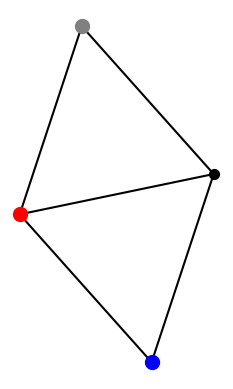

In [5]:
bdy = [Node(0, pos[0])]
source = [Node(2, pos[2])]
target = [Node(1, pos[1])]

e.boundary = bdy
e.sources = source
e.targets = target

print(bdy[0])

e.plot_state(e.x0)

## Network States

There are three relevant states, each with different boundary conditions.

* The equilibrium state is the least constrained: the boundary nodes are held fixed, but in general, all edge lengths return to their rest lengths
* The free state constrains the positions of both the boundary and source nodes
* The clamped state constrains the positions of the boundary, source, and target nodes. This is the most constrained state.

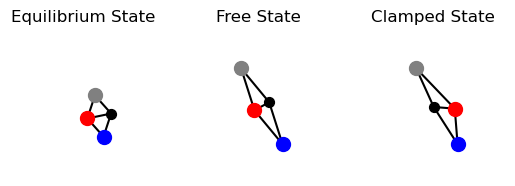

In [6]:
fig, axes = plt.subplots(1,3, sharey=True)
for ax in axes:
    ax.set_xlim(-1, 5)
    ax.set_ylim(-1, 5)
(ax1, ax2, ax3) = axes
ax1.set_title('Equilibrium State')
ax2.set_title('Free State')
ax3.set_title('Clamped State')
e.plot_state(e.x0, ax=ax1)
e.plot_state(e.free_state(), ax=ax2)
e.plot_state(e.clamped_state(), ax=ax3)

## Network Configurations

A network's "configuration" is the combination of all edges' learning degrees of freedom: the spring stiffnesses and rest lengths.

Changing the network's configuration changes its behavior: this is how we train the network.
Changing the rest lengths will change the equilibrium state of the network.

Edge stiffnesses:  [1. 1. 1. 1. 1.]
Edge rest lengths:  [1. 1. 1. 1. 1.]
New edge rest lengths:  [1.  1.  1.5 1.  1. ]


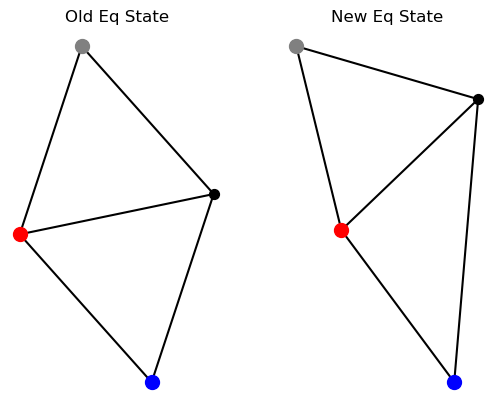

In [7]:
print('Edge stiffnesses: ', e.KS)
print('Edge rest lengths: ', e.RLS)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.set_title('Old Eq State')
e.plot_state(e.x0, ax=ax1)

RLS = e.RLS
RLS[2] = 1.5
e.RLS = RLS


print('New edge rest lengths: ', e.RLS)
ax2.set_title('New Eq State')
e.plot_state(e.x0, ax=ax2)

## Training Data

A single "data point" for training consists of a set of source/target value pairs.
The "input" will have shape (# source nodes, dim) where dim is the embedding dimension of your network.
The "output" will have shape (# target nodes, dim).

A single learning step consists of computing the free and clamped states for this data point, and then comparing them to update the network's configuration.

It is possible to train with multiple data points. In this case, training will cycle through each data point at each learning step. 

For now, we consider the simpler case where we have one data point, one source node, and one target node.

In [16]:
desiredin = [sn.position for sn in source]
desiredout = [tn.position for tn in target]

iopair = (desiredin, desiredout)

print('Input: Source node {} at position {}'.format(source[0].index, desiredin[0]))
print('Output: Target node {} at position {}'.format(target[0].index, desiredout[0]))

Input: Source node 2 at position [3.00944893 0.30664652]
Output: Target node 1 at position [2.89256276 1.77069482]


## Loss and Cost

There are two metrics which determine how far our network is from the "learned state".

* The LOSS function is the usual error metric from computational learning: the sum of squares of the error at the output nodes.

* The COST function is a physical metric: the difference in energy between the free and clamped states.

These two metrics need not be the same, but their derivatives in learning space should point in the same direction. In other words, they should both direct the network towards the learned state from anywhere in learning space, and they should both decrease over the course of training.

In [17]:
FS = e.free_state(desiredin)
CS = e.clamped_state(desiredin, desiredout)

print('Cost:', e.cost(FS, CS))

freeout = e.free_output(desiredin)

print('Loss:', e.loss(freeout, desiredout))

Cost: 0.22946572
Loss: 0.858039737220381
